Number of pixels per sample: 784
Grid size: 28x28
Padding size: 0


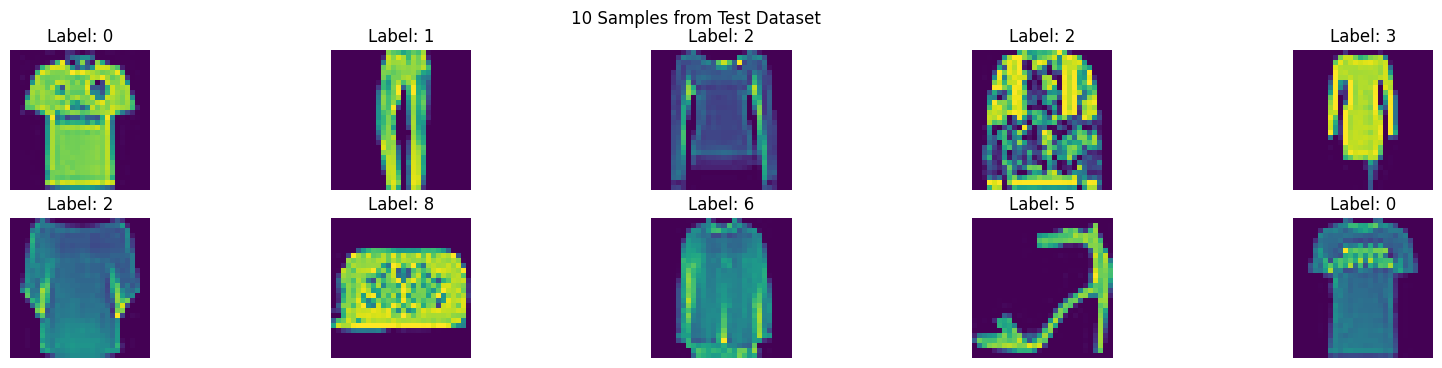

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

# Loading the test data
test = pd.read_csv('test.csv', nrows=2000)

# Loading the training data
train = pd.read_csv('train.csv', nrows=8000)

# Separating features and labels for test data
X_test, y_test = test.drop('label', axis=1), test['label']

# Separating features and labels for training data
X_train, y_train = train.drop('label', axis=1), train['label']

# Normalizing the feature values by dividing by 255
var = 255.0
X_test_scaled = X_test / var
X_train_scaled = X_train / var

samples = X_test_scaled[:10]

# Determining the maximum number of pixels among all samples to set grid size
num_pixels = samples.shape[1]
print(f"Number of pixels per sample: {num_pixels}")
grid_size = math.ceil(math.sqrt(num_pixels))
print(f"Grid size: {grid_size}x{grid_size}")
pad_size = (grid_size ** 2) - num_pixels
print(f"Padding size: {pad_size}")

# Plotting the graph
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(samples.iloc[i].values.reshape(grid_size, grid_size), cmap=None)
    ax.set_title(f"Label: {y_test.iloc[i]}")
    ax.axis('off')

plt.suptitle('10 Samples from Test Dataset')
plt.show()


Training MLP with activation function: logistic
Final Training Loss: 1.6676
Final Validation Loss: 1.6753
Test Accuracy: 0.4510

Training MLP with activation function: tanh
Final Training Loss: 0.4246
Final Validation Loss: 0.4552
Test Accuracy: 0.8315

Training MLP with activation function: relu
Final Training Loss: 0.4110
Final Validation Loss: 0.4439
Test Accuracy: 0.8360

Training MLP with activation function: identity
Final Training Loss: 0.4143
Final Validation Loss: 0.4533
Test Accuracy: 0.8275


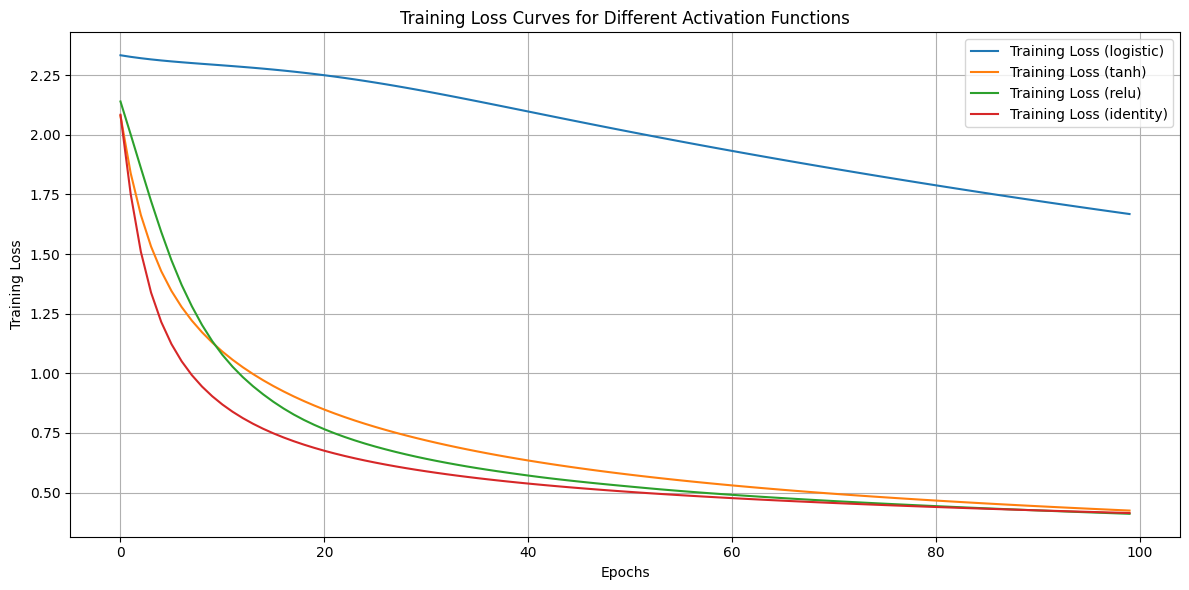

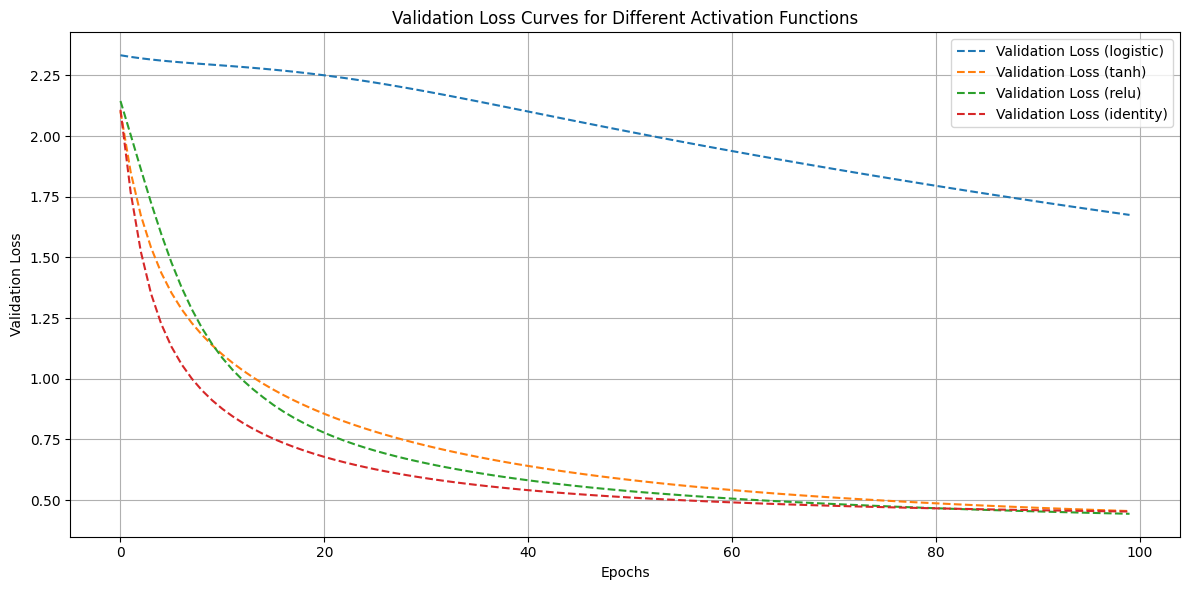



Test Accuracies for Different Activation Functions:
 - logistic: 0.4510
 - tanh: 0.8315
 - relu: 0.8360
 - identity: 0.8275

Best Activation Function: 'relu' with Test Accuracy: 0.8360


In [2]:
loss_curves = {}
validation_loss_curves = {}

# Spliting the training data into training and validation sets
split_data = train_test_split(X_train_scaled, y_train, test_size=0.125, random_state=42)
X_train_final, X_val, y_train_final, y_val = split_data

classes = np.unique(y_train_final)
test_accuracies = {}

# Iterating over each activation function
for activation in ['logistic', 'tanh', 'relu', 'identity']:
    print(f"\nTraining MLP with activation function: {activation}")
    
    # Initializing the MLPClassifier with specified hyperparameters
    mlp_params = {
    'hidden_layer_sizes': (128, 64, 32),
    'activation': activation,
    'solver': 'adam',
    'batch_size': 128,
    'learning_rate_init': 2e-5,
    'max_iter': 1,  # One iteration per partial_fit
    'warm_start': True,  # Keeping the weights between partial_fit calls
    'random_state': 42,
    'verbose': False,
    'early_stopping': False  # Disabling early stopping
    }

    mlp = MLPClassifier(**mlp_params)
    
    # Initialize the model with the first partial_fit call
    mlp.partial_fit(X_train_final, y_train_final, classes=classes)
    
    # Append initial losses
    training_loss = []
    training_loss.append(log_loss(y_train_final, mlp.predict_proba(X_train_final)))
    
    validation_loss = []
    validation_loss.append(log_loss(y_val, mlp.predict_proba(X_val)))
    
    
    # Training for 2 to 100 epochs
    for epoch in range(2, 101):
        mlp.partial_fit(X_train_final, y_train_final)
        
        # Predicting probabilities on the training set
        training_loss.append(log_loss(y_train_final, mlp.predict_proba(X_train_final)))
        
        # Predicting probabilities on the validation set
        validation_loss.append(log_loss(y_val, mlp.predict_proba(X_val)))

    # Storing the loss curves
    loss_curves[activation] = training_loss
    validation_loss_curves[activation] = validation_loss
    print(f"Final Training Loss: {training_loss[-1]:.4f}")
    # Calculating and storing the test accuracy
    accuracy = accuracy_score(y_test, mlp.predict(X_test_scaled))
    print(f"Final Validation Loss: {validation_loss[-1]:.4f}")
    test_accuracies[activation] = accuracy
    print(f"Test Accuracy: {accuracy:.4f}")

# Plotting training loss curves for different activation functions
plt.figure(figsize=(12, 6))
for activation in ['logistic', 'tanh', 'relu', 'identity']:
    plt.plot(loss_curves[activation], label=f'Training Loss ({activation})')
plt.title('Training Loss Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting validation loss curves for different activation functions
plt.figure(figsize=(12, 6))
for activation in ['logistic', 'tanh', 'relu', 'identity']:
    plt.plot(validation_loss_curves[activation], linestyle='--', label=f'Validation Loss ({activation})')
plt.title('Validation Loss Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Displaying test accuracies for each activation function
print("\n")
print("Test Accuracies for Different Activation Functions:")
for activation, accuracy in test_accuracies.items():
    act = activation
    acc = accuracy
    print(f" - {act}: {acc:.4f}")

# Identifying the best activation function based on test accuracy
print(f"\nBest Activation Function: '{max(test_accuracies, key=test_accuracies.get)}' with Test Accuracy: {test_accuracies[max(test_accuracies, key=test_accuracies.get)]:.4f}")


In [3]:
from sklearn.model_selection import GridSearchCV

print(f"Using best activation function from Part 2: 'relu'")
best_activation = 'relu'

mlp_params = {
    'hidden_layer_sizes': (128, 64, 32),
    'activation': best_activation,
    'max_iter': 100,
    'random_state': 42
}

mlp = MLPClassifier(**mlp_params)

# Using GridSearchCV to find the best hyperparameters
grid_params = {
    'estimator': mlp,
    'param_grid': {
        'solver': ['adam', 'sgd'],
        'learning_rate_init': [0.00001, 0.0001, 0.001],
        'batch_size': [64, 128, 256],
    },
    'cv': 3,  # 3-fold cross-validation
    'scoring': 'accuracy',  # Use accuracy as the scoring metric
    'verbose': 2,
    'n_jobs': -1  # Use all available cores
}

grid_search = GridSearchCV(**grid_params)

# Fitting the GridSearchCV on the training data
print("Starting grid search...")
grid_search.fit(X_train_scaled, y_train)
print("\n")
print("Best Hyperparameters:")
for param_name in sorted(grid_search.best_params_.keys()):
    p_name = param_name
    print(f" - {p_name}: {grid_search.best_params_[p_name]}")

print(f"\nBest Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluating the best model on the test set
test_accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test_scaled))
print(f"\nTest Accuracy of Best Model: {test_accuracy:.4f}")


Using best activation function from Part 2: 'relu'
Starting grid search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=sgd; total time=  37.9s
[CV] END batch_size=64, learning_rate_init=1e-05, solver=sgd; total time=  38.0s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=sgd; total time=  38.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=adam; total time=  43.0s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=1e-05, solver=adam; total time=  43.5s
[CV] END batch_size=64, learning_rate_init=0.0001, solver=adam; total time=  43.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.0001, solver=adam; total time=  43.7s
[CV] END batch_size=64, learning_rate_init=1e-05, solver=adam; total time=  43.9s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.0001, solver=sgd; total time=  39.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.0001, solver=sgd; total time=  39.7s
[CV] END batch_size=64, learning_rate_init=0.001, solver=adam; total time=  39.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.0001, solver=sgd; total time=  40.6s
[CV] END batch_size=64, learning_rate_init=0.001, solver=adam; total time=  40.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.0001, solver=adam; total time=  45.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.001, solver=sgd; total time=  40.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.001, solver=adam; total time=  45.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=sgd; total time=  31.1s
[CV] END batch_size=128, learning_rate_init=1e-05, solver=sgd; total time=  30.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=adam; total time=  33.0s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=adam; total time=  33.9s
[CV] END batch_size=128, learning_rate_init=1e-05, solver=adam; total time=  33.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.001, solver=sgd; total time=  39.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=64, learning_rate_init=0.001, solver=sgd; total time=  39.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=1e-05, solver=sgd; total time=  30.9s
[CV] END batch_size=128, learning_rate_init=0.001, solver=adam; total time=  24.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=0.0001, solver=sgd; total time=  30.7s
[CV] END batch_size=128, learning_rate_init=0.0001, solver=sgd; total time=  30.7s
[CV] END batch_size=128, learning_rate_init=0.0001, solver=sgd; total time=  30.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=0.0001, solver=adam; total time=  33.3s
[CV] END batch_size=128, learning_rate_init=0.0001, solver=adam; total time=  33.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=0.0001, solver=adam; total time=  33.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=0.001, solver=adam; total time=  33.8s
[CV] END batch_size=128, learning_rate_init=0.001, solver=adam; total time=  30.0s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=1e-05, solver=adam; total time=  27.8s
[CV] END batch_size=256, learning_rate_init=1e-05, solver=adam; total time=  28.2s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=1e-05, solver=adam; total time=  27.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=128, learning_rate_init=0.001, solver=sgd; total time=  30.5s
[CV] END batch_size=128, learning_rate_init=0.001, solver=sgd; total time=  30.6s
[CV] END batch_size=128, learning_rate_init=0.001, solver=sgd; total time=  30.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=1e-05, solver=sgd; total time=  26.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=1e-05, solver=sgd; total time=  26.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=1e-05, solver=sgd; total time=  26.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.0001, solver=adam; total time=  27.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.0001, solver=sgd; total time=  26.4s
[CV] END batch_size=256, learning_rate_init=0.0001, solver=sgd; total time=  26.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.0001, solver=adam; total time=  27.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.0001, solver=adam; total time=  27.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.0001, solver=sgd; total time=  26.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.001, solver=adam; total time=  24.1s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.001, solver=sgd; total time=  21.7s
[CV] END batch_size=256, learning_rate_init=0.001, solver=adam; total time=  23.1s
[CV] END batch_size=256, learning_rate_init=0.001, solver=sgd; total time=  21.8s
[CV] END batch_size=256, learning_rate_init=0.001, solver=sgd; total time=  21.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END batch_size=256, learning_rate_init=0.001, solver=adam; total time=  22.5s


Best Hyperparameters:
 - batch_size: 64
 - learning_rate_init: 0.001
 - solver: adam

Best Cross-Validation Accuracy: 0.8619

Test Accuracy of Best Model: 0.8475




Training MLPRegressor with activation function: relu
Final Training Loss: 0.022850
Final Validation Loss: 0.023132


Training MLPRegressor with activation function: identity
Final Training Loss: 0.021113
Final Validation Loss: 0.021404


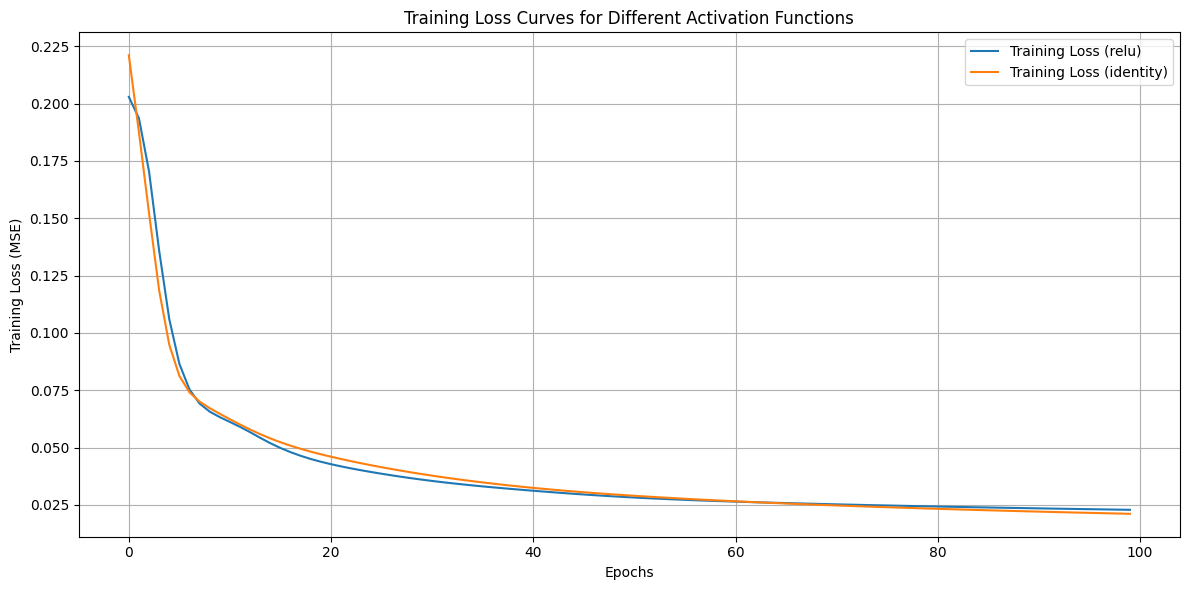

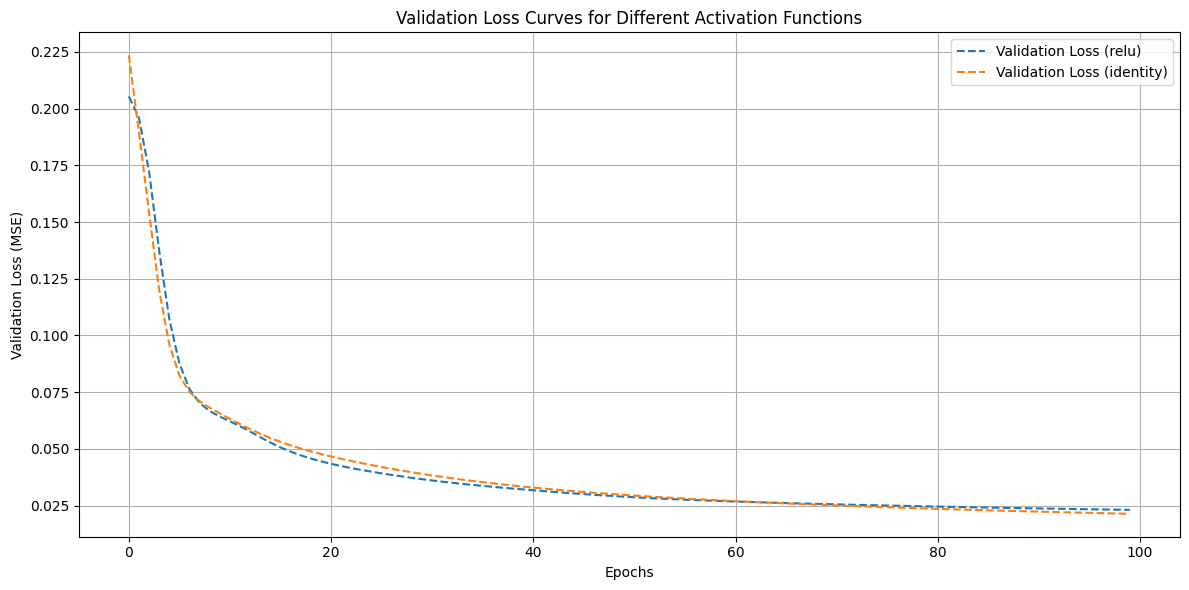



Visualizing regenerated images with activation function: relu


<Figure size 2000x400 with 0 Axes>

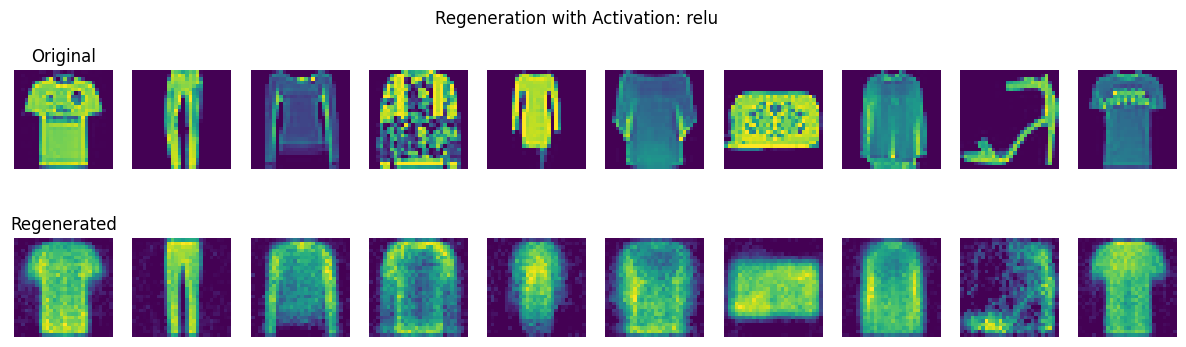



Visualizing regenerated images with activation function: identity


<Figure size 2000x400 with 0 Axes>

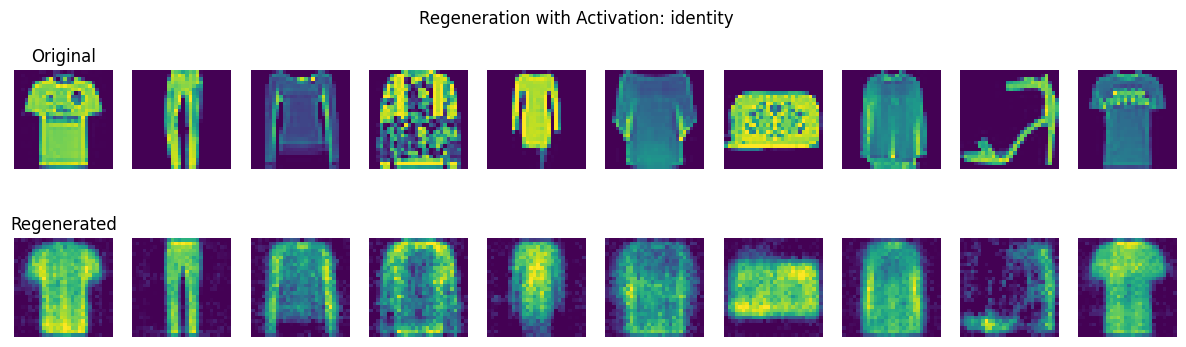

In [4]:
validation_loss_curves = {}

# Spliting the training data into training and validation sets
split_data = train_test_split(X_train_scaled, test_size=0.125, random_state=42)
X_train_regress, X_val_regress = split_data

mlp_reg_models = {}  # Dictionary to store the trained models
# Defining layer sizes [c, b, a, b, c], where c > b > a
a = 64
b = 128
c = 256

training_loss_curves = {}
for activation in ['relu', 'identity']:
    training_loss = []
    validation_loss = []
    print("\n")
    print(f"Training MLPRegressor with activation function: {activation}")
    
    # Initializing the MLPRegressor
    mlp_params = {
    'hidden_layer_sizes': [c, b, a, b, c],
    'activation': activation,
    'solver': 'adam',
    'learning_rate_init': 2e-5,
    'max_iter': 1,  
    'warm_start': True,
    'random_state': 42,
    'verbose': False
    }

    mlp_reg = MLPRegressor(**mlp_params)
    
    # Training for 100 epochs
    for epoch in range(1, 101):
        mlp_reg.partial_fit(X_train_regress, X_train_regress)
        
        # Calculate training loss (mean squared error)
        training_loss.append(np.mean((mlp_reg.predict(X_train_regress) - X_train_regress) ** 2))
        
        # Calculate validation loss
        validation_loss.append(np.mean((mlp_reg.predict(X_val_regress) - X_val_regress) ** 2))
    
    
    # Storing the loss curves
    training_loss_curves[activation] = training_loss
    print(f"Final Training Loss: {training_loss[-1]:.6f}")
    validation_loss_curves[activation] = validation_loss
    print(f"Final Validation Loss: {validation_loss[-1]:.6f}")
    # Saving the trained model
    mlp_reg_models[activation] = mlp_reg
    
# Plotting training and validation loss curves for both activation functions
plt.figure(figsize=(12, 6))
for activation in ['relu', 'identity']:
    plt.plot(training_loss_curves[activation], label=f'Training Loss ({activation})')
plt.title('Training Loss Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Training Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for activation in ['relu', 'identity']:
    plt.plot(validation_loss_curves[activation], linestyle='--', label=f'Validation Loss ({activation})')
plt.title('Validation Loss Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for activation in ['relu', 'identity']:
    print("\n")
    print(f"Visualizing regenerated images with activation function: {activation}")
    
    norm = 255.0
    # Rescaling the data back to original pixel values by multiplying by 255
    test_samples_original = X_test_scaled[:10] * norm
    regenerated_samples_original = mlp_reg_models[activation].predict(X_test_scaled[:10]) * norm
    
    # Cliping the pixel values to valid range (0-255)
    cli = 255
    test_samples_original = np.clip(test_samples_original, 0, cli)
    regenerated_samples_original = np.clip(regenerated_samples_original, 0, cli)
    
    # Converting to NumPy arrays if not already
    test_samples_original = np.array(test_samples_original)
    var = 0
    regenerated_samples_original = np.array(regenerated_samples_original)
    
    # Plotting the original and regenerated images side by side
    plt.figure(figsize=(20, 4))
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))

    for i, (sample, regenerated_sample) in enumerate(zip(test_samples_original[:10], regenerated_samples_original[:10])):
        # Original image
        ax = axes[0, i]
        sample_image = sample.reshape(28, 28)
        ax.imshow(sample_image, cmap=None)
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Regenerated image
        ax = axes[1, i]
        regenerated_image = regenerated_sample.reshape(28, 28)
        ax.imshow(regenerated_image, cmap=None)
        ax.axis('off')
        if i == 0:
            ax.set_title('Regenerated')

    plt.suptitle(f'Regeneration with Activation: {activation}')
    plt.show()


In [5]:
bottleneck_train_activations = {}
def relu(X):
    var = np.maximum(0, X)
    return var
bottleneck_test_activations = {}
def identity(X):
    var = X
    return var

def mlp_forward(X, coefs, intercepts, activation_func):
    temp = 0
    activations = [X]
    for i in range(len(coefs)):
        if i == len(coefs) - 1:
            A = np.dot(activations[i], coefs[i]) + intercepts[i] 
        else:
            A = activation_func(np.dot(activations[i], coefs[i]) + intercepts[i])
        activations.append(A)
    temp+=1
    return activations

for activation in ['relu', 'identity']:
    print("\n")
    print(f"Extracting bottleneck features using activation function: {activation}")
    
    if activation == 'relu':
        activation_func = relu
    elif activation == 'identity':
        activation_func = identity
    
    # Getting activations for training data
    bottleneck_train_activations[activation] = mlp_forward(X_train_scaled, mlp_reg_models[activation].coefs_, mlp_reg_models[activation].intercepts_, activation_func)[3] 
    
    # Getting activations for test data
    bottleneck_test_activations[activation] = mlp_forward(X_test_scaled, mlp_reg_models[activation].coefs_, mlp_reg_models[activation].intercepts_, activation_func)[3]

# Training MLP Classifiers on the extracted bottleneck features
test_accuracies_part5 = {}

for activation in ['relu', 'identity']:
    print("\n")
    print(f"Training MLPClassifier on bottleneck features with activation function: {activation}")
    
    # Initializing the MLPClassifier
    mlp_clf_params = {
        'hidden_layer_sizes': (a, a),
        'activation': activation,
        'solver': 'adam',
        'batch_size': 128,
        'learning_rate_init': 2e-5,
        'max_iter': 200,
        'random_state': 42,
        'verbose': False
    }

    mlp_clf = MLPClassifier(**mlp_clf_params)

    # Training the classifier
    mlp_clf.fit(bottleneck_train_activations[activation], y_train)
    
    # Predicting on test data
    y_test_pred = mlp_clf.predict(bottleneck_test_activations[activation])
    
    # Calculating test accuracy
    accuracy = accuracy_score(y_test, y_test_pred)
    accu = accuracy
    test_accuracies_part5[activation] = accu
    
    print(f"Test Accuracy: {accu:.4f}")

# Displaying test accuracies
print("\nTest Accuracies for MLPClassifiers trained on bottleneck features:")
for activation, accuracy in test_accuracies_part5.items():
    act = activation
    acc = accuracy
    print(f" - {act}: {acc:.4f}")



Extracting bottleneck features using activation function: relu


Extracting bottleneck features using activation function: identity


Training MLPClassifier on bottleneck features with activation function: relu


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.7640


Training MLPClassifier on bottleneck features with activation function: identity
Test Accuracy: 0.7935

Test Accuracies for MLPClassifiers trained on bottleneck features:
 - relu: 0.7640
 - identity: 0.7935


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
